# RFM-анализ  
RFM-анализ представляет собой мощный инструмент для анализа и оптимизации маркетинговых стратегий на основе изучения клиентской базы. Данный подход позволяет оценить ценность и поведение клиентов по 3 параметрам: **Recency** - давность последней активности клиента, **Frequency** - частота покупок клиента, **Monetary** - сумма потраченных денежных средств.  
В данном ноутбуке произведен RFM-анализ покупок товаров в онлайн-ритейле с целью сегментации клиентов и проведения различных маркетинговых кампаний для разных групп покупателей.

### Подготовка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import sqlalchemy as sql
import portfolio_db_cred as cred
import keyring
import matplotlib.pyplot as plt

In [2]:
# Загрузка датасета, первое представление о датасете
db_password = keyring.get_password('portfolio_db', cred.user)
con = sql.create_engine(f'postgresql+psycopg2://{cred.user}:{db_password}@{cred.host}:{cred.port}/postgres')
df = pd.read_sql('SELECT * FROM rfm_retail_data', con)
print(f'Размер датасета: {df.shape}', end='\n\n')
print(df.info(), end='\n\n')
df.sample(5)

Размер датасета: (525461, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB
None



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
15825,490709,21327,SKULLS WRITING SET,1,12/7/2009 15:15,1.65,17884.0,United Kingdom
482773,534656,21671,RED SPOT CERAMIC DRAWER KNOB,6,11/23/2010 13:36,1.25,13869.0,United Kingdom
188635,507290,21977,PACK OF 60 PINK PAISLEY CAKE CASES,1,5/7/2010 14:10,0.55,14814.0,United Kingdom
79961,496651,47567B,TEA TIME KITCHEN APRON,1,2/3/2010 12:21,5.95,13553.0,United Kingdom
351987,523638,21906,PHARMACIE FIRST AID TIN,4,9/23/2010 12:01,6.75,13097.0,United Kingdom


#### Описание полей:
* 0 - Invoice - уникальный ID заказа
* 1 - StockCode - укникальный ID товара
* 2 - Description - описание товара
* 3 - Quantity - количество
* 4 - InvoiceDate - дата создания заказа 
* 5 - Price - цена одной единицы товара
* 6 - Customer ID - уникальный ID клиента
* 7 - Country - страна проживания клиента

In [3]:
# Проверяем пропуски в % от общего числа строк
# при необходимости - обрабатываем пропуски
df.isna().mean() 

Invoice        0.000000
StockCode      0.000000
Description    0.005572
Quantity       0.000000
InvoiceDate    0.000000
Price          0.000000
Customer ID    0.205395
Country        0.000000
dtype: float64

Пропуски обнаружены в полях описания и ID клиента. Пропуски в ID клиента критичны для проведения RFM-анализа. Исключим данные строки. Следует поставить задачу на предотвращение и обработку пропусков.

In [4]:
# Убираем пропуски фильтрацией
df = df[~df['Customer ID'].isna()]

In [5]:
# Особенности датасета: исключаем отмененные заказы (ID заказа начинается с "С")
df = df[~df['Invoice'].str.startswith('C')]

In [6]:
# Проверяем дубликаты
df[df.duplicated()].shape

(6748, 8)

Обнаружены дубликаты записей, следует очистить.

In [7]:
# Удаляем дубликаты
df = df.drop_duplicates()

In [8]:
# Преобразуем дату размещения заказа в надлежащий формат
# установлен американский формат даты, пропускаем параметр dayfirst
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Проверяем количество ошибочных значений в поле "дата заказа"
print(f"Wrong date: {df['InvoiceDate'].isnull().sum()}")

Wrong date: 0


In [9]:
# Преобразуем ID пользователя в строку, удаляем некорректные символы
df['Customer ID'] = df['Customer ID'].astype(str)
df['Customer ID'] = df['Customer ID'].str.rstrip('.0')

In [10]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [11]:
# Посмотрим описательную статистику
df.describe()

,Quantity,InvoiceDate,Price
count,400947.000000,400947,400947.000000
mean,13.768523,2010-07-01 04:56:11.466452992,3.305571
min,1.000000,2009-12-01 07:45:00,0.000000
25%,2.000000,2010-03-26 13:13:00,1.250000
50%,5.000000,2010-07-09 10:26:00,1.950000
75%,12.000000,2010-10-14 13:57:00,3.750000
max,19152.000000,2010-12-09 20:01:00,10953.500000
std,97.639816,NaN,35.046376


In [12]:
print(f'Количество заказов без учета отмененных, дубликатов, пропусков ID клиента: {df.shape[0]}')

Количество заказов без учета отмененных, дубликатов, пропусков ID клиента: 400947


In [13]:
# добавим поле стоимости заказа: количество * цена
df['Sales'] = df['Quantity'] * df['Price']
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales
252338,513747,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-06-28 12:27:00,0.21,16571,United Kingdom,10.08
481965,534524,47590A,BLUE HAPPY BIRTHDAY BUNTING,3,2010-11-23 12:03:00,5.45,16155,United Kingdom,16.35
78244,496502,35004C,SET OF 3 COLOURED FLYING DUCKS,3,2010-02-02 09:39:00,5.45,17146,United Kingdom,16.35
373474,525443,21877,HOME SWEET HOME MUG,4,2010-10-05 13:48:00,1.25,14085,United Kingdom,5.00
77474,496444,22262,FELT EGG COSY CHICKEN,6,2010-02-01 13:52:00,0.85,15311,United Kingdom,5.10


# Приступаем к RFM-анализу

In [14]:
# Оставляем только нужные поля
df_rfm = df[['Customer ID', 'Invoice', 'Sales', 'InvoiceDate']].copy()
print(f'Shape: {df_rfm.shape}', end='\n\n')
print(df_rfm.sample(5))

Shape: (400947, 4)

       Customer ID Invoice  Sales         InvoiceDate
520947       16385  537792   11.8 2010-12-08 12:56:00
485796       16794  534814    2.5 2010-11-24 12:45:00
212949       18242  510049   30.0 2010-05-27 09:08:00
503867       17377  536500    7.9 2010-12-01 12:35:00
82896        13694  496994  165.0 2010-02-05 11:32:00


In [15]:
# Находим максимальную дату
max_order_date = df_rfm['InvoiceDate'].max()
print(f'Максимальная дата заказа: {max_order_date}')

# Указанная дата будет служить отправной датой для RFM-анализа, т.к. мы предполагаем, 
# что анализ производится во время текущей деятельности организации


Максимальная дата заказа: 2010-12-09 20:01:00


In [16]:
# Группируем подготовленный датасет по ID клиента
rfm_result = df_rfm.groupby('Customer ID').agg({
                                                'InvoiceDate': lambda x: (max_order_date - x.max()).days, # Recency
                                                'Invoice': lambda x: len(x.unique()), # Frequency
                                                'Sales': 'sum' # Monetary
                                                })
rfm_result.rename(columns={
                        'InvoiceDate': 'Recency',
                        'Invoice': 'Frequency',
                        'Sales': 'Monetary'
                          }, inplace=True)
print(f'Размер RFM таблицы: {rfm_result.shape}')
print('Случайная выборка:', rfm_result.sample(5), sep='\n')

Размер RFM таблицы: (4314, 3)
Случайная выборка:
             Recency  Frequency  Monetary
Customer ID                              
14168             55          2    370.45
15991            169          1    150.55
15465              4         15   5281.53
18009            177          7   1896.84
13965            111          3    996.61


In [17]:
# Ознакомимся с описательной статистикой
rfm_result.describe()

,Recency,Frequency,Monetary
count,4314.000000,4314.000000,4314.000000
mean,90.269124,4.454103,2039.460766
std,96.943482,8.168658,8909.797773
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,307.105000
50%,52.000000,2.000000,700.405000
75%,135.000000,5.000000,1713.297500
max,373.000000,205.000000,349164.350000


In [18]:
# Выделяем квартили, формируем RFM
rfm_result["recency_score"] = pd.qcut(rfm_result['Recency'], 3, labels=[3, 2, 1])

rfm_result["frequency_score"] = pd.qcut(rfm_result['Frequency'].rank(method="first"), 3, labels=[1, 2, 3])

rfm_result["monetary_score"] = pd.qcut(rfm_result['Monetary'], 3, labels=[1, 2, 3])

rfm_result["RFM_score"] = (rfm_result['recency_score'].astype(str) +
                    rfm_result['frequency_score'].astype(str) +
                    rfm_result['monetary_score'].astype(str)
                   )

In [19]:
rfm_result.sort_values(by='RFM_score', ascending=False)

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_score
Customer ID,,,,,,,
18287,17,4,2345.71,3,3,3,333
1323,0,17,3457.83,3,3,3,333
15793,13,5,1433.96,3,3,3,333
15785,14,11,3640.96,3,3,3,333
15769,6,21,32451.60,3,3,3,333
...,...,...,...,...,...,...,...
15293,300,1,247.50,1,1,1,111
12771,120,1,282.30,1,1,1,111
17336,107,1,81.12,1,1,1,111


# Бизнес-выводы и принятие решений

Оценим величину групп пользователей, согласно RFM-анализа.

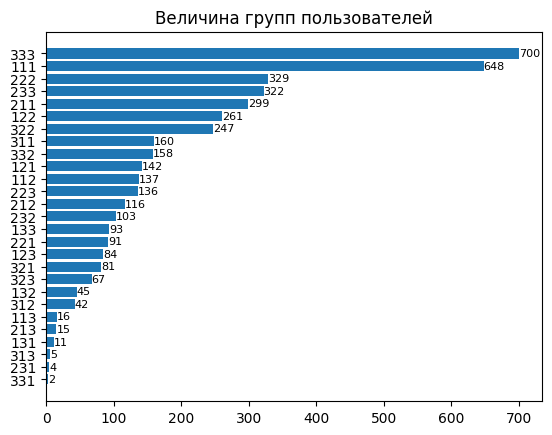

In [20]:
rfm_bar = rfm_result['RFM_score'].value_counts(ascending=True)

fig, axes = plt.subplots(1, 1)

bars = axes.barh(rfm_bar.index, rfm_bar)
axes.set_title('Величина групп пользователей')
axes.bar_label(bars, fontsize=8)
plt.show()

**Кто наши лучшие клиенты?**  
Для данного сегмента рекомендуется отправить особое предложение, например приглашение в VIP-клуб лучших клиентов с соответствующими привелегиями.
Сохраним ID указанных клиентов для дальнейшей рассылки уведомлений.

In [21]:
print(f'Количество пользователей: {rfm_result[rfm_result['RFM_score'] == '333'].shape[0]}')
list_of_333 = rfm_result[rfm_result['RFM_score'] == '333'].index.values
print('Список пользователей сохранен в list_of_333.')

Количество пользователей: 700
Список пользователей сохранен в list_of_333.


**Кто наши постоянные клиенты?**  
Наши клиенты, которые стабильно совершают покупки, но при этом не являются VIP-клиентами. Для данного сегмента рекомендуется предпринять попытку увеличения среднего чека допродажей сопутствующих товаров или направить специальные предложения.

In [22]:
print(f'Количество пользователей: {rfm_result[rfm_result['RFM_score'].isin(['321', '322','331', '332'])].shape[0]}')
list_of_stable_cust = rfm_result[rfm_result['RFM_score'].isin(['321', '322','331', '332'])].index.values
print('Список пользователей сохранен в list_of_stable_cust.')

# Сегмент 323 - постоянные клиенты с высоким чеком - не стоит их утомлять лишними рассылками, направленными на повышение среднего чека

Количество пользователей: 488
Список пользователей сохранен в list_of_stable_cust.


**Работа с новичками**  
Выявляем клиентов-новичков, которые недавно совершили первые покупки. Рекомендуется отправить welcome-цепочки и иные интересные предложения для удержания интереса

In [23]:
print(f'Количество пользователей: {rfm_result[rfm_result['RFM_score'].isin(['311', '312','313'])].shape[0]}')
list_of_new_cust = rfm_result[rfm_result['RFM_score'].isin(['311', '312','313'])].index.values
print('Список пользователей сохранен в list_of_new_cust.')

Количество пользователей: 207
Список пользователей сохранен в list_of_new_cust.


**Уходящие клиенты**  
Клиенты, находящиеся на пороге оттока. Следует обязательно провести работу с данной категорией клиентов. Рекомендуется сбор обратной связи  
для выявления причин оттока, проведение стимулирующих акций.

In [24]:
print(f'Количество пользователей: {rfm_result[rfm_result['RFM_score'].isin(['121', '122','123', '211', '212', '213', '221', '222', 
                                                                            '223', '231', '222', '223'])].shape[0]}')
list_of_lost = rfm_result[rfm_result['RFM_score'].isin(['121', '122','123', '211', '212', '213', '221', '222', '223', '231', '222', 
                                                            '223'])].index.values
print('Список пользователей сохранен в list_of_lost.')

Количество пользователей: 1477
Список пользователей сохранен в list_of_lost.


**Уходящие постоянные**  
Постоянные клиенты, находящиеся на пороге оттока, в том числе клиенты с высоким показателем Monetary - сумма потраченных денег. Крайне важно  
направить реактивационные письма, собрать обратную связь, предложить программы лояльности, возможно, совершить личный звонок.

In [25]:
print(f'Количество пользователей: {rfm_result[rfm_result['RFM_score'].isin(['131', '132', '133'])].shape[0]}')
list_of_stable_lost = rfm_result[rfm_result['RFM_score'].isin(['131', '132', '133'])].index.values
print('Список пользователей сохранен в list_of_stable_lost.')

Количество пользователей: 149
Список пользователей сохранен в list_of_stable_lost.


**Иные категории**  
В зависимости от потребностей и особенностей бизнеса, возможно выделение дополнительных категорий, путем увеличения количества групп в каждом из параметров RFM. Существуют кейсы, в которых RFM предполагает 5 категорий, что позволяет более прицельно проводить маркетинговые методики для привлечения и удержания клиентов.  
Кроме того, допустимо деление на категории не по квартилям, а с учетом неоднородности клиентской базы, основываясь на анализе данных, что позволит учесть особенности бизнеса и подстроить RFM-анализ под актуальные требования и цели.

## Вывод
RFM-анализ - мощный инструмент для понимания клиентской базы и проведения маркетинговой стратегии. Это позволяет более эффективно настраивать маркетинговые кампании и увеличивать прибыльность.